In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
from fastai import *
import pandas as pd

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/root/.fastai/data/imdb_sample/data_save.pkl')]

In [0]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [0]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A TextDataBunch does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [0]:
data_lm.save()

In [0]:
data = load_data(path)

#**Tokenization**

In [0]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


#**Numericalization**:-
Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token UNK.

The correspondance from ids to tokens is stored in the vocab attribute of our datasets, in a dictionary called itos (for int to string).

In [0]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [0]:
data.train_ds[0][0]

Text xxbos " xxmaj deliverance " is one of the best exploitation films to come out of that wonderful 1970 's decade from whence so many other exploitation films came . 
 
  a group of friends sets out on a xxunk trip down a river in the south and they become victimized by a bunch of toothless xxunk who pretty much try to ruin their lives . xxmaj it 's awesome . 
 
  xxmaj we are treated to anal rape , vicious beatings , bow and arrow killings , shootings , broken bones , etc ... a lot like 1974 's " xxmaj texas xxmaj chainsaw xxmaj massacre , " to say that " xxmaj deliverance " is believable would be immature . xxmaj this would never and could never happen , even in the dark ages of 1972 . 
 
  " xxmaj deliverance " is a very entertaining ride and packed full of action . xxmaj it is one in a huge pile of exploitation films to come from the early 70 's and it ( xxunk ) sits on top of that pile with it 's great acting , superb cinematography and excellent writing . 
 
  8 out of 10 , kid

But the underlying text is all numbers

In [0]:
data.train_ds[0][0].data[:10]

array([   2,   22,    5, 3791,   22,   16,   44,   14,    9,  142])

# **WITH DATABLOCK API**
We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

#**LANGUAGE MODEL**

In [0]:
#Language model can use a lot of GPU. Hence reduce the batch size
bs = 48

In [0]:
#Now lets grab the whole dataset
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/train')]

In [0]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/pos')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an unsup folder on top of train and test that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called wikitext-103). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [0]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"him of his son . xxmaj this kid seems to be xxup ok , but he has a troubled past . xxmaj he will be released in a few weeks and xxmaj hunter must find out if that is correct . xxmaj we as viewers no pretty soon , that it is not and hope that xxmaj hunter finds out before the deadline as well ... \n \n xxmaj"
1,"tex xxmaj ritter and xxmaj milli xxmaj xxunk . xxmaj jerry , for a good many reasons , does his best to destroy xxmaj tom 's romantic intentions ( hey , what are "" friends "" for ? ) and largely succeeds . xxmaj at cartoon 's end , we leave amid the strains of another musical interlude and a twisted variation on an old cliche of the western genre"
2,"be xxmaj gulliver . xxmaj it actually might have worked better . xxmaj instead they chose to use a process that the xxmaj fleischer 's , xxmaj max and xxmaj dave invented called xxmaj rotoscope where they film an actor and trace his features into animation . xxmaj sam xxmaj parker is the voice and features of xxmaj gulliver . xxmaj longtime xxmaj disney xxmaj pinto xxmaj colvig , best"
3,"for the cool . xxmaj in fact , he is kind of an annoying brat that you 'd like to smack over the head . xxmaj especially if you 're a cop trying to get him to court and bullets are flying at you . xxmaj this refreshing approach breathes a sort of life into the movie and the film moves even farther from "" goofy action movie "" category"
4,"is even recommended book for elementary school children , so if you find the book version , do n't hesitate to buy it . xxmaj for smaller kids the comic book is available also . xxmaj have fun with the book or xxup vhs / xxup dvd as well :) xxbos xxmaj this is a tough one to review . xxmaj there are bits and pieces that are really striking"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02
Min loss divided by 10: 6.92E-03


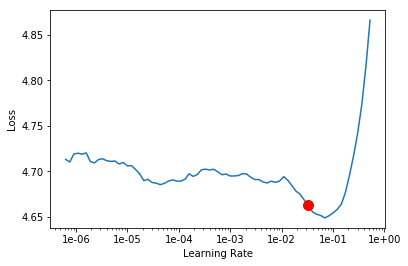

In [0]:
learn.recorder.plot(skip_end=15,suggestion=True)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,4.161420,4.019917,0.296347,1:29:35


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head')

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it was so good i was better at watching it than the Hollywood movie i missed in Holland . i was very disappointed with a lot of movies that i had done know dozens of times in all
I liked this movie because it was a good story . It was a very good movie , but i think it is a perfect movie , so i was pleasantly surprised by the remake . i saw it in Austin Powers


In [0]:
learn.save_encoder('fit_head_enc')

#**Classifier**

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos * * * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . * * * \n \n xxmaj before i begin , i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that",neg
"xxbos i thought that xxup rotj was clearly the best out of the three xxmaj star xxmaj wars movies . i find it surprising that xxup rotj is considered the weakest installment in the xxmaj trilogy by many who have voted . xxmaj to me it seemed like xxup rotj was the best because it had the most profound plot , the most suspense , surprises , most xxunk the",pos
"xxbos i 've rented and watched this movie for the 1st time on xxup dvd without reading any reviews about it . xxmaj so , after 15 minutes of watching i 've noticed that something is wrong with this movie ; it 's xxup terrible ! i mean , in the trailers it looked scary and serious ! \n \n i think that xxmaj eli xxmaj roth ( xxmaj",neg
"xxbos xxmaj on xxmaj sunday xxmaj july 27 , 1997 , the first episode of a new science fiction series called "" xxmaj stargate xxup sg-1 "" was broadcast on xxmaj showtime . a spin - off of and sequel to the 1994 film "" xxmaj stargate "" starring xxmaj kurt xxmaj russell and xxmaj james xxmaj spader , the series begins approximately one year after the events portrayed in",pos


We can then create a model to classify those reviews and load the encoder we saved earlier 


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fit_head_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj this must be one of the most overrated xxmaj spanish films in history . xxmaj its lack of subtlety and complexity and its total political correction make it really childish , with only good / bad characters . xxmaj the world is just not like this , and good movies show complex characters with opposite impulses , dilemmas , etc . xxmaj however , what i xxup hate most about this film is xxmaj xxunk 's friend 's father . xxmaj the director tries to teach us a good lesson : tattoo artists with shaved heads are not always bad guys , in fact they can be better than the average looking dad ( wow , this is like ... philosophy , or something ) . xxmaj thank you , xxmaj xxunk . i 'll propose you for the xxmaj nobel prize of literature .,xxbos i read about this movie in a magazine and i was intrigued . a woman , who one day sees herself drive past in her own car . xxmaj well , i thought , this could be inte

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 1.45E-02


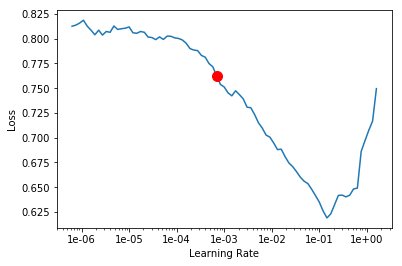

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(1, 6.92e-04, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.426062,0.341344,0.849200,10:52


In [0]:
learn.save('first')

In [0]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj this must be one of the most overrated xxmaj spanish films in history . xxmaj its lack of subtlety and complexity and its total political correction make it really childish , with only good / bad characters . xxmaj the world is just not like this , and good movies show complex characters with opposite impulses , dilemmas , etc . xxmaj however , what i xxup hate most about this film is xxmaj xxunk 's friend 's father . xxmaj the director tries to teach us a good lesson : tattoo artists with shaved heads are not always bad guys , in fact they can be better than the average looking dad ( wow , this is like ... philosophy , or something ) . xxmaj thank you , xxmaj xxunk . i 'll propose you for the xxmaj nobel prize of literature .,xxbos i read about this movie in a magazine and i was intrigued . a woman , who one day sees herself drive past in her own car . xxmaj well , i thought , this could be inte

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(6.92e-04/(2.6**4),6.92e-04), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.365659,0.283451,0.883600,10:42


In [0]:
learn.save('second')

In [0]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([2.8555e-05, 9.9997e-01]))